In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import shutil
from pathlib import Path

from result_analysis.helper_functions import (
  process_csv_data,
)

In [2]:
features_original_format = pd.read_csv("/home/csoare/experiments/feature_analysis3/features.csv")

In [3]:
features = process_csv_data("/home/csoare/experiments/feature_analysis3/features.csv")

# Total instances
total_instances = len(features)

# Display statistics
print(f"Total number of instances: {total_instances}")
# Print number of instances per generator
instances_per_generator = features['generator'].value_counts()
print("Number of instances per generator:")
print(instances_per_generator)

def find_missing_instances(cnf_dir: str, features_csv: str) -> list:
    """
    Find CNF files that were not processed in the features CSV.
    
    Args:
        cnf_dir (str): Directory containing the original CNF files
        features_csv (str): Path to the features CSV file
        
    Returns:
        list: Names of CNF files that were not processed
    """
    import pandas as pd
    from pathlib import Path
    
    # Read all CNF filenames
    cnf_files = set()
    for cnf_file in Path(cnf_dir).glob("*.cnf"):
        cnf_files.add(cnf_file.stem)
    
    # Read processed instances from CSV
    df = pd.read_csv(features_csv)
    processed_instances = set(df['instance_name'])
    
    # Find missing instances
    missing = cnf_files - processed_instances
    
    return sorted(list(missing))

missing = find_missing_instances("/home/csoare/experiments/feature_analysis3/instances/cnf", "/home/csoare/experiments/feature_analysis3/features.csv")
if missing:
    print(f"Found {len(missing)} unprocessed instances:")
    for instance in missing:
        print(f"  - {instance}")
else:
    print("All CNF files were processed successfully")

print(features.columns)
    

Total number of instances: 10000
Number of instances per generator:
generator
PairSAT-hard-100    1000
FuzzSAT-easy-50     1000
PairSAT-easy-100    1000
PairSAT-hard-0      1000
FuzzSAT-easy-0      1000
PairSAT-easy-0      1000
FuzzSAT-hard-50     1000
FuzzSAT-hard-0      1000
FuzzSAT-easy-100    1000
FuzzSAT-hard-100    1000
Name: count, dtype: int64
All CNF files were processed successfully
Index(['nvarsOrig', 'nclausesOrig', 'nvars', 'nclauses', 'reducedVars',
       'reducedClauses', 'Pre-featuretime', 'vars-clauses-ratio',
       'POSNEG-RATIO-CLAUSE-mean', 'POSNEG-RATIO-CLAUSE-coeff-variation',
       'POSNEG-RATIO-CLAUSE-min', 'POSNEG-RATIO-CLAUSE-max',
       'POSNEG-RATIO-CLAUSE-entropy', 'VCG-CLAUSE-mean',
       'VCG-CLAUSE-coeff-variation', 'VCG-CLAUSE-min', 'VCG-CLAUSE-max',
       'VCG-CLAUSE-entropy', 'UNARY', 'BINARY+', 'TRINARY+',
       'Basic-featuretime', 'VCG-VAR-mean', 'VCG-VAR-coeff-variation',
       'VCG-VAR-min', 'VCG-VAR-max', 'VCG-VAR-entropy',
       'POSNE

In [4]:
# Verify the new columns
print("\nUnique presumed difficulties:", features['presumed_difficulty'].unique())
print("Unique randomness values:", features['randomness'].unique())


Unique presumed difficulties: ['hard' 'easy']
Unique randomness values: ['100' '50' '0']


In [5]:
# Helper function for all analyses
def get_satzilla_features(df):
    """Get numeric features, excluding metadata columns"""
    features_to_exclude = ['seed', 'randomness', 'solved']
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    return [col for col in numeric_cols if col not in features_to_exclude]

In [6]:
def select_distribution_preserving_instances(satzilla_features, instances_per_generator=100):
    """
    Select instances while preserving the original distribution of features.
    Ensures exactly instances_per_generator instances are selected for each generator.
    
    Args:
        satzilla_features (pd.DataFrame): Original dataset with features
        instances_per_generator (int): Number of instances to select per generator
        
    Returns:
        pd.DataFrame: Selected instances maintaining original distribution
    """
    results = []
    
    for generator in satzilla_features['generator'].unique():
        generator_instances = satzilla_features[satzilla_features['generator'] == generator].copy()
        
        # If we have fewer instances than requested, take all of them
        if len(generator_instances) <= instances_per_generator:
            # Randomly duplicate instances if we have fewer than required
            if len(generator_instances) < instances_per_generator:
                n_duplicates = instances_per_generator - len(generator_instances)
                duplicate_indices = np.random.choice(len(generator_instances), size=n_duplicates, replace=True)
                duplicates = generator_instances.iloc[duplicate_indices]
                generator_instances = pd.concat([generator_instances, duplicates])
            results.append(generator_instances)
            continue
            
        feature_columns = get_satzilla_features(generator_instances)
        features = generator_instances[feature_columns]
        
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Create bins for each feature to stratify the sampling
        n_bins = min(10, len(generator_instances) // 20)  # Adaptive bin size
        bin_labels = []
        
        for i in range(scaled_features.shape[1]):
            bins = pd.qcut(scaled_features[:, i], q=n_bins, labels=False, duplicates='drop')
            bin_labels.append(bins)
            
        # Combine bin labels to create strata
        combined_bins = np.vstack(bin_labels).T
        strata = ['_'.join(map(str, row)) for row in combined_bins]
        
        # Calculate target size for each stratum
        stratum_counts = pd.Series(strata).value_counts()
        total_samples = len(strata)
        target_sizes = {}
        
        remaining_instances = instances_per_generator
        
        # First pass: allocate minimum sizes
        for stratum in stratum_counts.index:
            proportion = stratum_counts[stratum] / total_samples
            target_size = max(1, int(instances_per_generator * proportion))
            # Make sure we don't exceed remaining instances
            target_size = min(target_size, remaining_instances)
            target_sizes[stratum] = target_size
            remaining_instances -= target_size
            
        # Second pass: distribute any remaining instances
        if remaining_instances > 0:
            strata_by_size = sorted(stratum_counts.items(), key=lambda x: x[1], reverse=True)
            for stratum, _ in strata_by_size:
                if remaining_instances <= 0:
                    break
                target_sizes[stratum] += 1
                remaining_instances -= 1
                
        # Select instances from each stratum
        selected_indices = []
        for stratum in target_sizes:
            if target_sizes[stratum] == 0:
                continue
                
            stratum_indices = np.where(np.array(strata) == stratum)[0]
            if len(stratum_indices) > 0:
                # Handle case where we need more samples than available
                size = target_sizes[stratum]
                if size > len(stratum_indices):
                    # Take all available indices
                    selected_indices.extend(stratum_indices)
                    # Randomly sample the remaining with replacement
                    additional_samples = np.random.choice(
                        stratum_indices,
                        size=size - len(stratum_indices),
                        replace=True
                    )
                    selected_indices.extend(additional_samples)
                else:
                    # Normal case: sample without replacement
                    selected_from_stratum = np.random.choice(
                        stratum_indices,
                        size=size,
                        replace=False
                    )
                    selected_indices.extend(selected_from_stratum)
        
        selected_instances = generator_instances.iloc[selected_indices]
        
        # Double-check we have exactly the right number of instances
        if len(selected_instances) < instances_per_generator:
            n_missing = instances_per_generator - len(selected_instances)
            additional_samples = generator_instances.sample(n=n_missing, replace=True)
            selected_instances = pd.concat([selected_instances, additional_samples])
        elif len(selected_instances) > instances_per_generator:
            selected_instances = selected_instances.sample(n=instances_per_generator, replace=False)
            
        results.append(selected_instances)
        
    return pd.concat(results, axis=0)

selected_dataset = select_distribution_preserving_instances(features, instances_per_generator=100)

<Figure size 640x480 with 0 Axes>

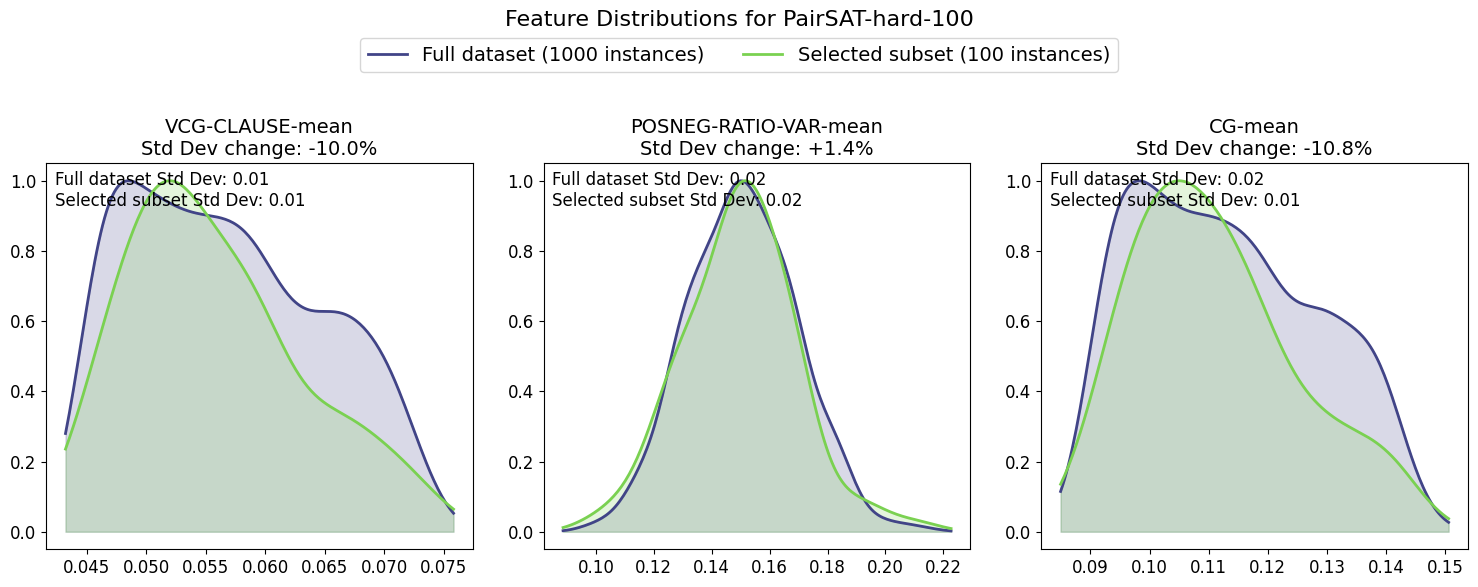

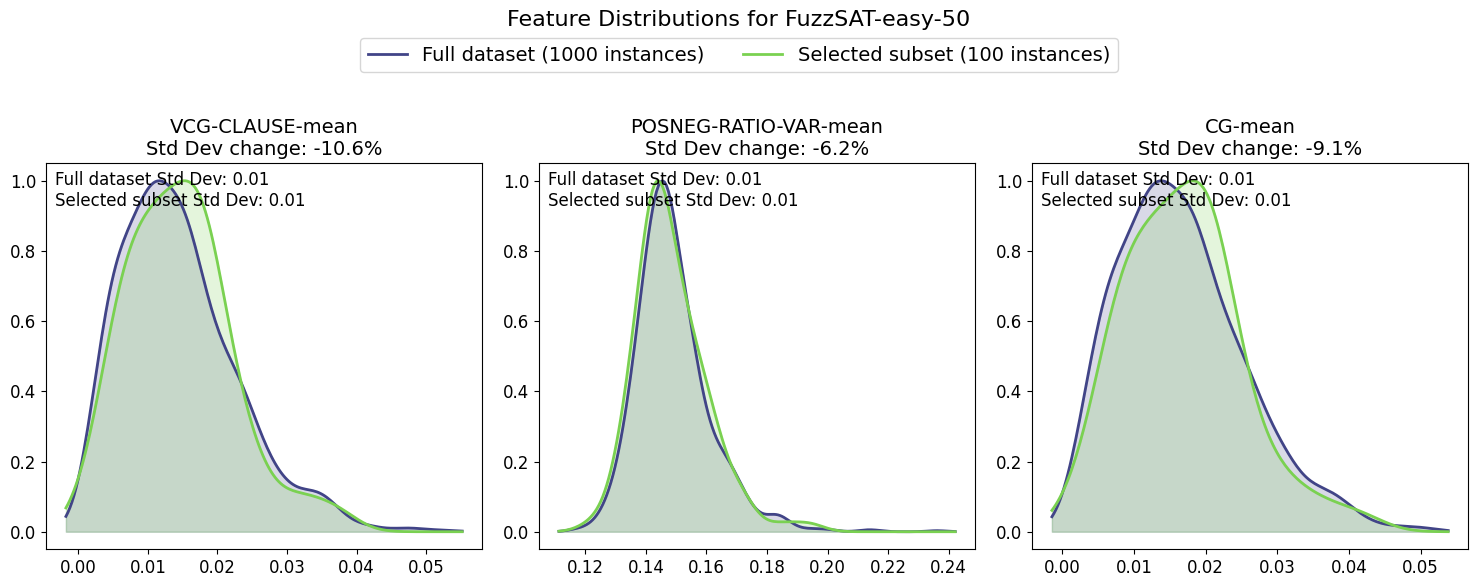

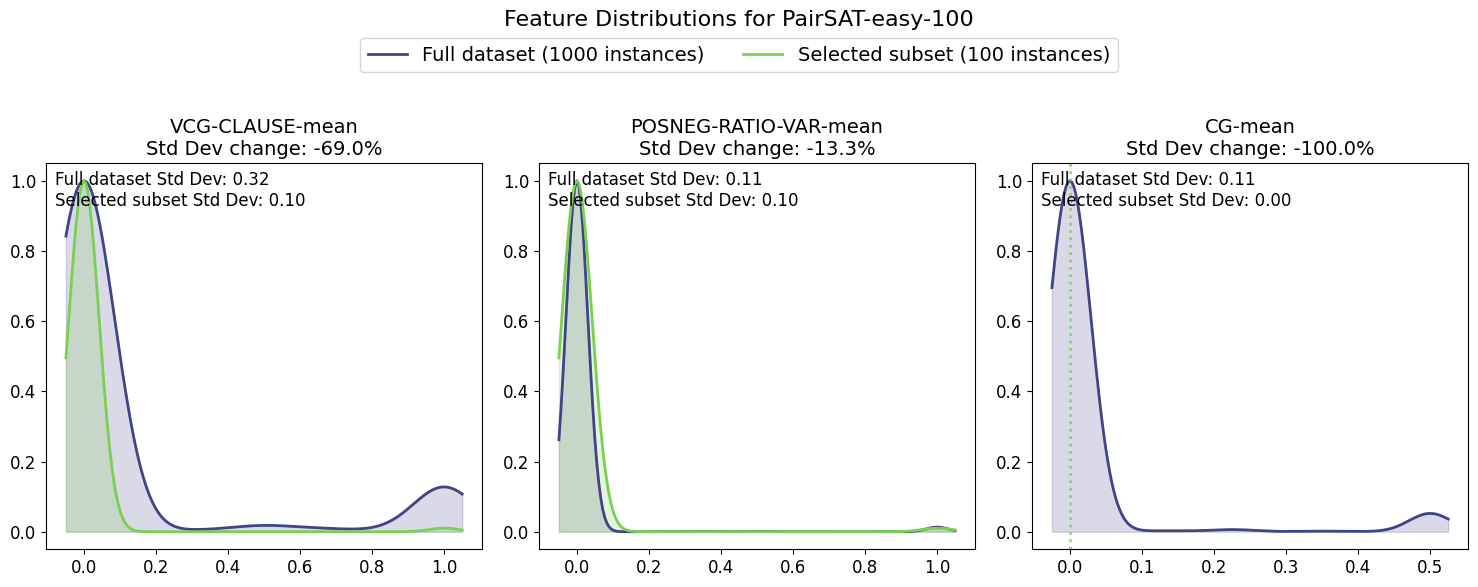

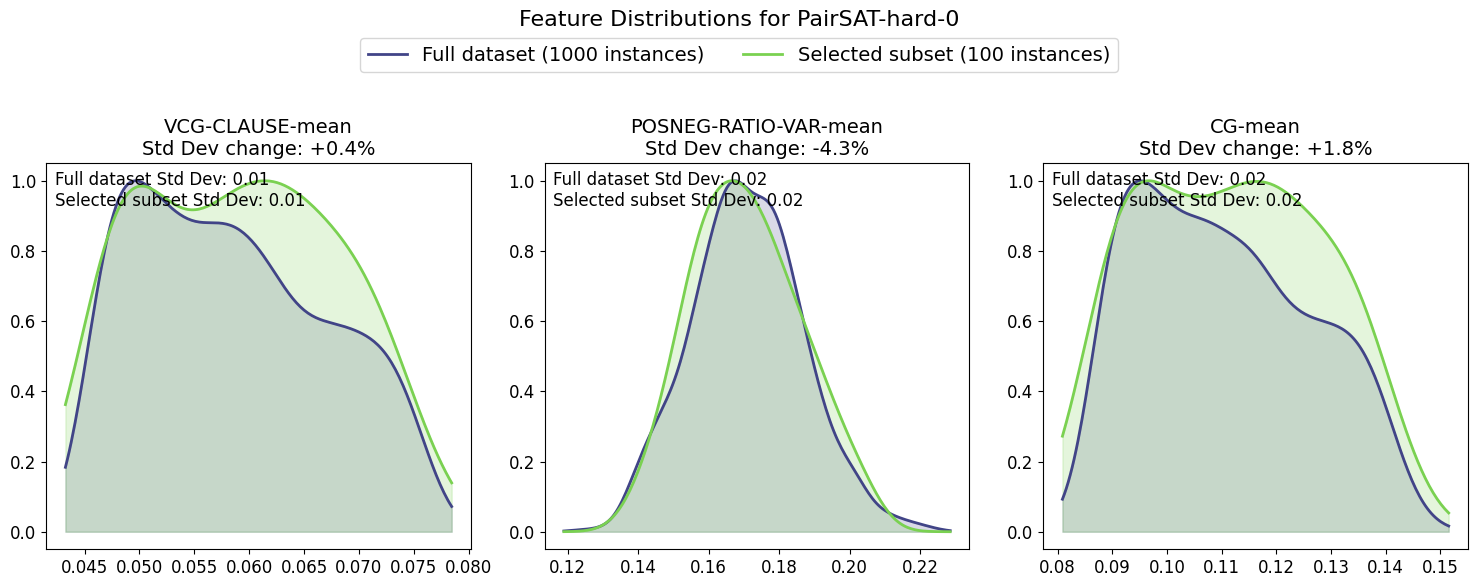

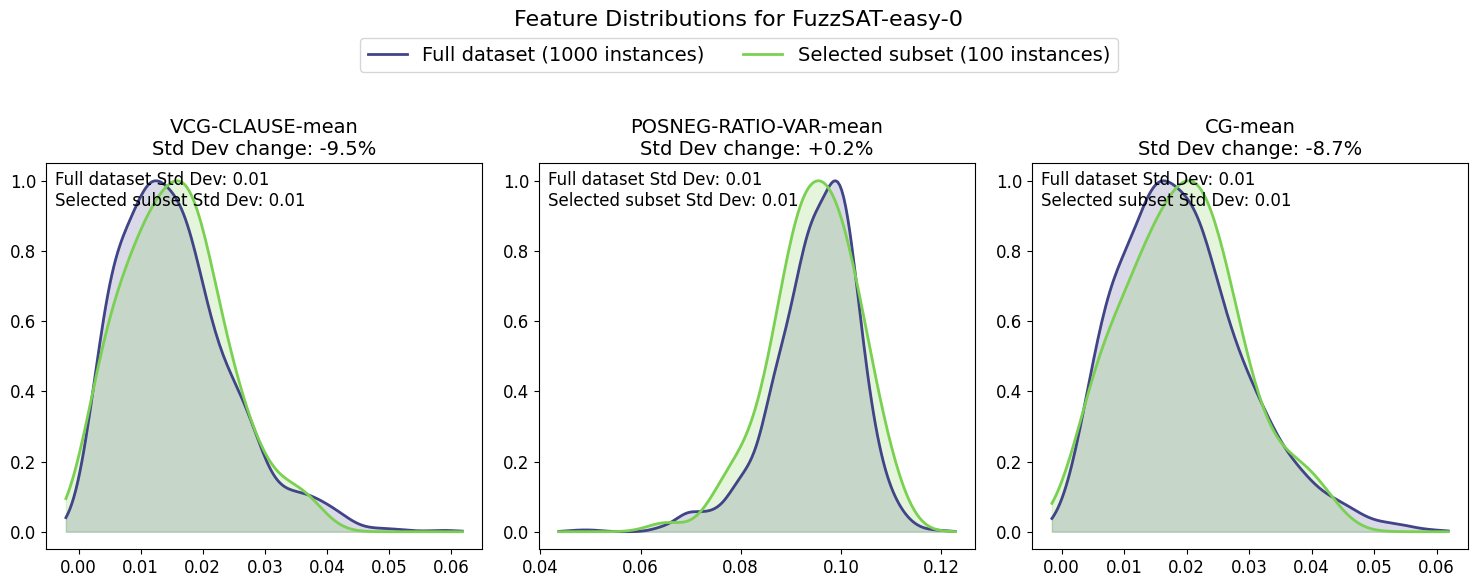

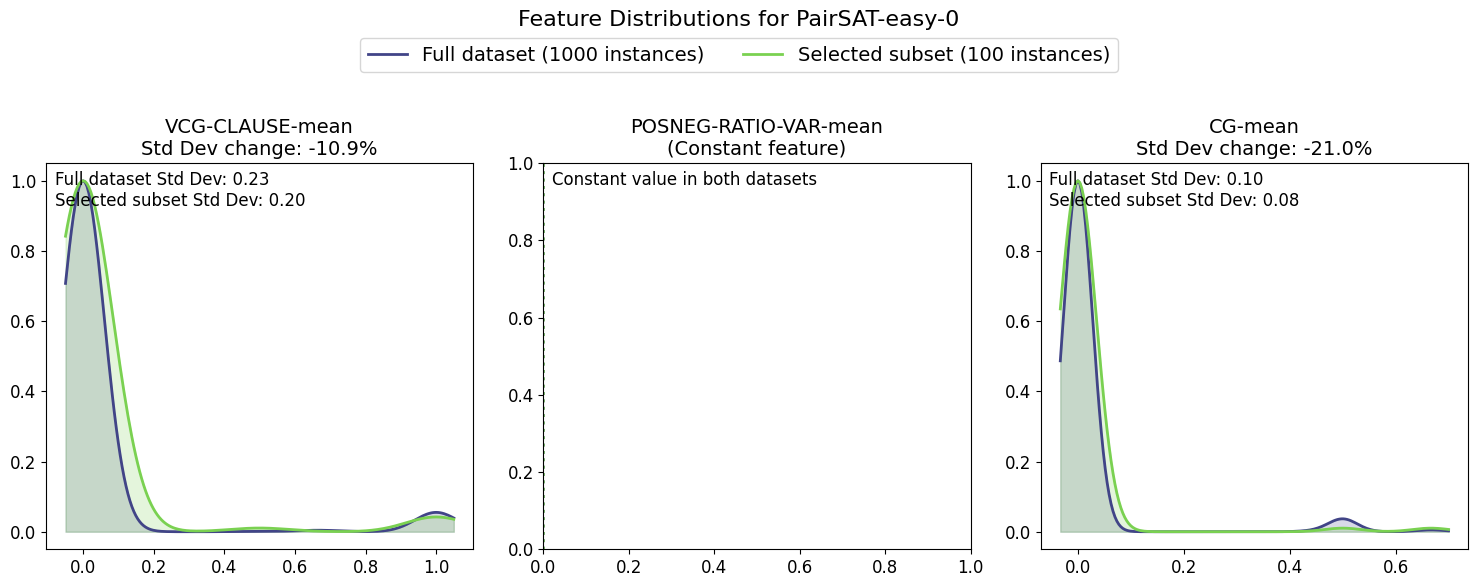

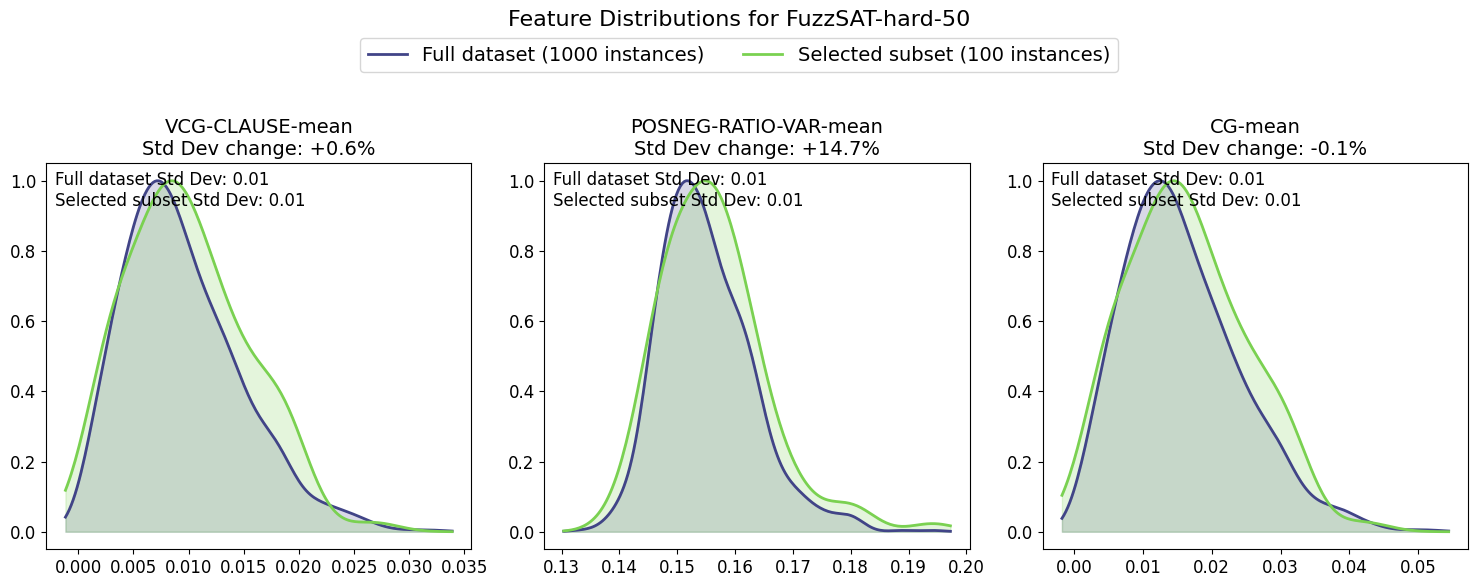

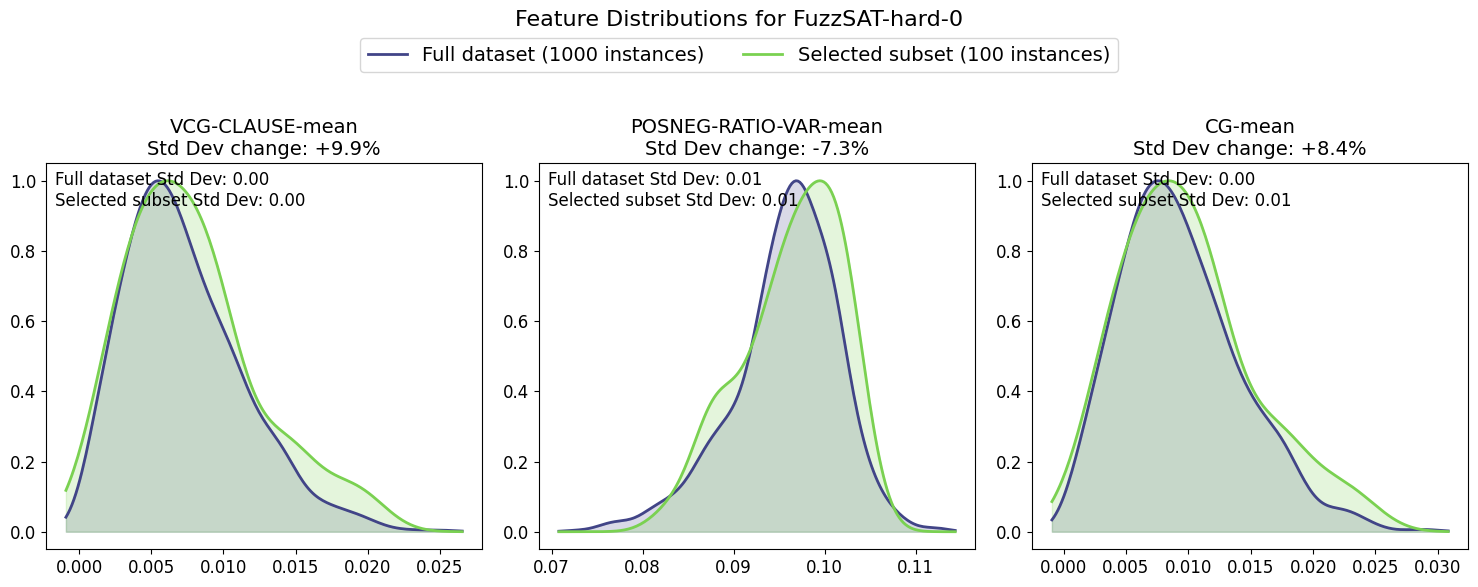

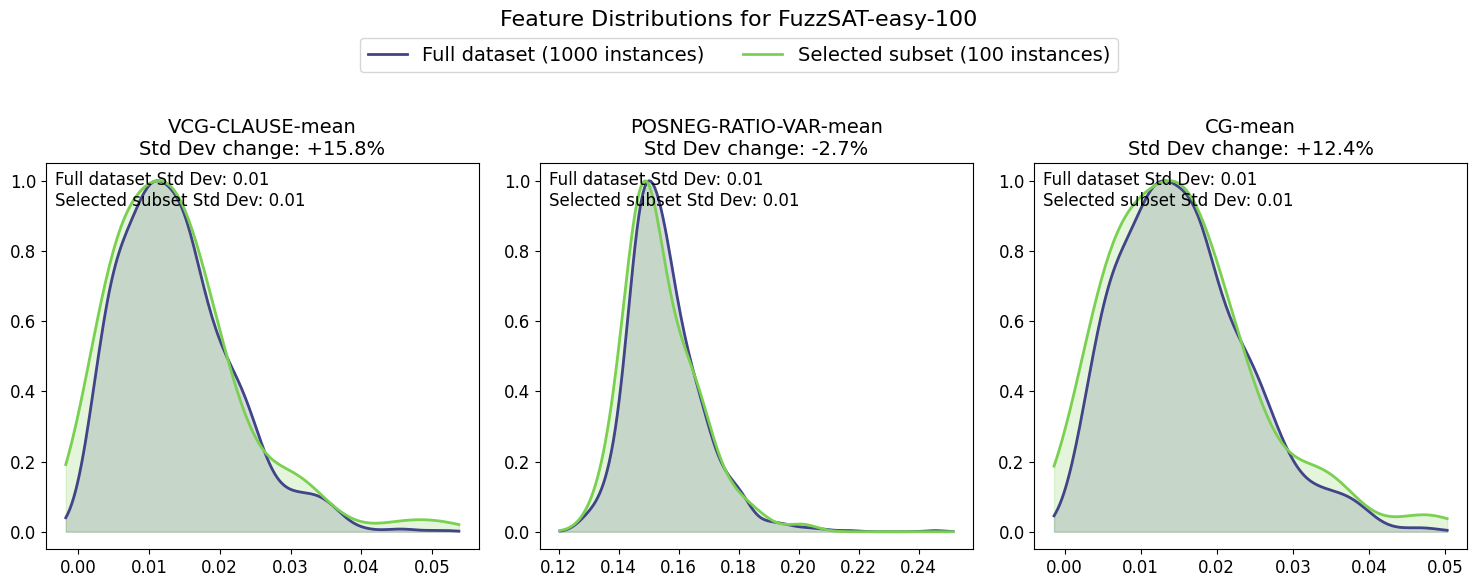

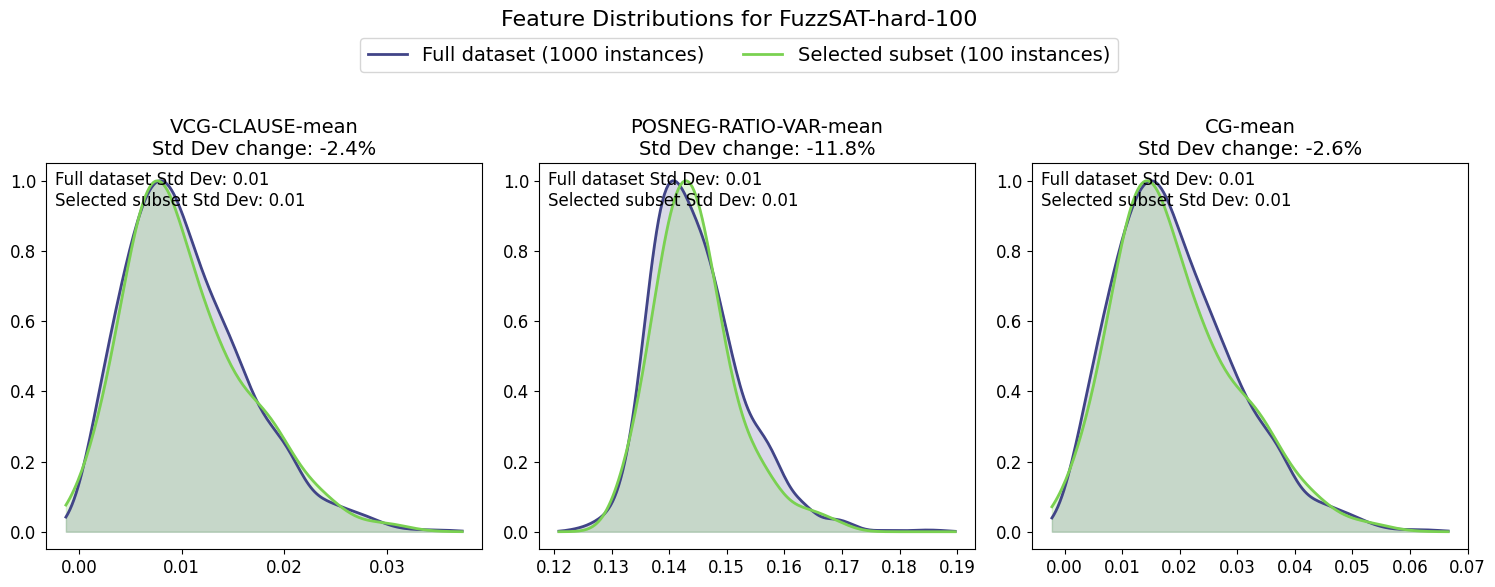

In [16]:
plt.set_cmap('viridis')
plt.rcParams.update({'font.size': 14})

def plot_feature_distributions(original_df, selected_df, feature_cols):
    """Plot PDF comparisons for features before and after selection for each generator."""
    plt.set_cmap('viridis')
    plt.rcParams.update({'font.size': 14})
    
    for generator in original_df['generator'].unique():
        n_rows = (len(feature_cols) + 2) // 3
        fig = plt.figure(figsize=(15, 5*n_rows + 1))  # Added extra space for legend
        
        # Create a gridspec with space for the legend
        gs = plt.GridSpec(n_rows + 1, 3, height_ratios=[0.1] + [1]*n_rows)
        
        # Create figure-level legend handles
        legend_handles = []
        legend_labels = []
        
        fig.suptitle(f'Feature Distributions for {generator}', fontsize=16, y=0.98)
        
        orig_data = original_df[original_df['generator'] == generator]
        sel_data = selected_df[selected_df['generator'] == generator]
        
        orig_color = plt.cm.viridis(0.2)
        sel_color = plt.cm.viridis(0.8)
        
        for idx, feature in enumerate(feature_cols):
            row = idx // 3 + 1  # +1 because first row is for legend
            col = idx % 3
            ax = fig.add_subplot(gs[row, col])
            
            orig_feature = orig_data[feature].values
            sel_feature = sel_data[feature].values
            
            # Define common x-range for both distributions
            x_min = min(np.min(orig_feature), np.min(sel_feature))
            x_max = max(np.max(orig_feature), np.max(sel_feature))
            
            range_width = x_max - x_min
            x_min -= range_width * 0.05 if range_width > 0 else 0.5
            x_max += range_width * 0.05 if range_width > 0 else 0.5
            
            xs = np.linspace(x_min, x_max, 200)
            
            # Plot distributions
            is_orig_constant = orig_data[feature].nunique() == 1
            is_sel_constant = sel_data[feature].nunique() == 1
            
            # Original distribution
            if is_orig_constant:
                value = orig_feature[0]
                line1 = ax.axvline(x=value, color=orig_color, 
                                 label='Full dataset (1000 instances)', 
                                 linestyle=':', linewidth=2, alpha=0.8)
            else:
                try:
                    if orig_feature.std() < 1e-6:
                        orig_feature = orig_feature + np.random.normal(0, 1e-6, len(orig_feature))
                    
                    density = gaussian_kde(orig_feature, bw_method='silverman')
                    ys = density(xs)
                    ys = ys / (np.max(ys) + 1e-10)
                    line1 = ax.plot(xs, ys, color=orig_color, linewidth=2,
                                  label='Full dataset (1000 instances)')[0]
                    ax.fill_between(xs, ys, alpha=0.2, color=orig_color)
                except Exception:
                    # Fallback to histogram for numerical issues
                    counts, bins, patches = ax.hist(orig_feature, bins=30, density=True,
                                                  alpha=0.3, color=orig_color,
                                                  label='Full dataset (1000 instances)')
                    line1 = ax.axvline(np.median(orig_feature), color=orig_color,
                                     linestyle='--')
            
            # Selected distribution
            if is_sel_constant:
                value = sel_feature[0]
                line2 = ax.axvline(x=value, color=sel_color,
                                 label='Selected subset (100 instances)', 
                                 linestyle=':', linewidth=2, alpha=0.8)
            else:
                try:
                    if sel_feature.std() < 1e-6:
                        sel_feature = sel_feature + np.random.normal(0, 1e-6, len(sel_feature))
                    
                    density = gaussian_kde(sel_feature, bw_method='silverman')
                    ys = density(xs)
                    ys = ys / (np.max(ys) + 1e-10)
                    line2 = ax.plot(xs, ys, color=sel_color, linewidth=2,
                                  label='Selected subset (100 instances)')[0]
                    ax.fill_between(xs, ys, alpha=0.2, color=sel_color)
                except Exception:
                    counts, bins, patches = ax.hist(sel_feature, bins=30, density=True,
                                                  alpha=0.3, color=sel_color,
                                                  label='Selected subset (100 instances)')
                    line2 = ax.axvline(np.median(sel_feature), color=sel_color,
                                     linestyle='--')
            
            if idx == 0:  # Only add to legend handles once
                legend_handles.extend([line1, line2])
                legend_labels.extend(['Full dataset (1000 instances)', 'Selected subset (100 instances)'])
            
            # Calculate statistics
            orig_std = orig_feature.std()
            sel_std = sel_feature.std()
            if orig_std == 0:
                stats_text = "Constant value in both datasets"
                title_text = f"{feature}\n(Constant feature)"
            else:
                diff_pct = ((sel_std / orig_std) - 1) * 100
                stats_text = (f'Full dataset Std Dev: {orig_std:.2f}\n'
                            f'Selected subset Std Dev: {sel_std:.2f}')
                title_text = f'{feature}\nStd Dev change: {diff_pct:+.1f}%'
            
            ax.set_title(title_text, fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            ax.text(0.02, 0.98, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   fontsize=12)
        
        # Add the legend in the reserved space at the top
        fig.legend(legend_handles, legend_labels,
                  loc='upper center',
                  bbox_to_anchor=(0.5, 0.95),
                  ncol=2,
                  fontsize=14)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

selected_features = ['VCG-CLAUSE-mean', 'POSNEG-RATIO-VAR-mean', 'CG-mean']
plot_feature_distributions(features, selected_dataset, selected_features)


In [8]:
def organize_selected_instances(satzilla_features_original, selected_dataset, source_cnf_dir, target_base_dir):
    """
    Organize selected CNF files into folders based on base generator and difficulty.
    Only processes instances from selected_dataset but maintains features format from original.
    
    Args:
        satzilla_features_original (pd.DataFrame): Original DataFrame containing all instance features
        selected_dataset (pd.DataFrame): DataFrame containing the selected instances
        source_cnf_dir (str): Directory containing source CNF files
        target_base_dir (str): Target directory for organized files
        
    Returns:
        dict: Statistics about copied files
    """
    target_base_path = Path(target_base_dir)
    target_base_path.mkdir(parents=True, exist_ok=True)
    source_path = Path(source_cnf_dir)
    
    stats = {
        'total_copied': 0,
        'files_per_group': {},
        'successfully_copied': []  # Track which instances were actually copied
    }
    
    # Parse generator and difficulty from instance names
    def get_generator_info(instance_name):
        parts = instance_name.split('_')[0].split('-')
        if len(parts) >= 3:
            base_generator = parts[0]
            difficulty = parts[1]
            return base_generator, difficulty
        return None, None
    
    # Get list of selected instance names
    selected_instances = selected_dataset.index.tolist()
    
    # Group instances by base generator and difficulty
    instance_groups = {}
    for instance in selected_instances:
        base_generator, difficulty = get_generator_info(instance)
        if base_generator and difficulty:
            group_key = f"{base_generator}-{difficulty}"
            if group_key not in instance_groups:
                instance_groups[group_key] = []
            instance_groups[group_key].append(instance)
    
    # Copy files to appropriate directories
    for group_dir_name, instances in instance_groups.items():
        group_dir = target_base_path / group_dir_name
        group_dir.mkdir(exist_ok=True)
        files_copied = 0
        
        for instance in instances:
            source_file = source_path / f"{instance}.cnf"
            target_file = group_dir / f"{instance}.cnf"
            
            try:
                if source_file.exists():
                    shutil.copy2(source_file, target_file)
                    files_copied += 1
                    stats['successfully_copied'].append(instance)
                else:
                    print(f"Warning: Source file not found: {source_file}")
            except Exception as e:
                print(f"Error copying {instance}: {str(e)}")
        
        stats['files_per_group'][group_dir_name] = files_copied
        stats['total_copied'] += files_copied
    
    # Save features only for successfully copied instances
    if stats['successfully_copied']:
        # Filter features for only successfully copied instances from the original format
        features_output = satzilla_features_original[
            satzilla_features_original['instance_name'].isin(stats['successfully_copied'])
        ]
        
        # Save to CSV in target directory
        features_output_path = target_base_path / 'features_output.csv'
        features_output.to_csv(features_output_path, index=False)  # Don't include index since instance_name is a column
        print(f"\nFeatures saved to: {features_output_path}")
        
        # Add to stats
        stats['features_file'] = str(features_output_path)
        stats['features_count'] = len(features_output)
    
    return stats

# Usage example:
source_dir = "/home/csoare/experiments/feature_analysis3/instances/cnf"
target_dir = "/home/csoare/experiments/reduced_instances_FINAL_MASIV_LASCONI"
stats = organize_selected_instances(features_original_format, selected_dataset, source_dir, target_dir)

print("\nCopying complete!")
print(f"Total files copied: {stats['total_copied']}")
print(f"Features saved for {stats['features_count']} instances")
print("\nFiles copied per group:")
for group, count in stats['files_per_group'].items():
    print(f"{group}: {count} files")


Features saved to: /home/csoare/experiments/reduced_instances_FINAL_MASIV_LASCONI/features_output.csv

Copying complete!
Total files copied: 1000
Features saved for 1000 instances

Files copied per group:
PairSAT-hard: 200 files
FuzzSAT-easy: 300 files
PairSAT-easy: 200 files
FuzzSAT-hard: 300 files


In [9]:
def select_random_instances_and_save(satzilla_features: pd.DataFrame, seed: int, randomness: int = 100, output_file: str = 'selected_instances.txt') -> pd.DataFrame:
    """
    Select one random instance from each base generator + difficulty combination,
    only considering instances with specified randomness, and save to text file.
    
    Args:
        satzilla_features (pd.DataFrame): DataFrame containing instance features
        seed (int): Random seed for reproducibility
        randomness (int): Randomness value to filter instances
        output_file (str): Path to the output text file
        
    Returns:
        pd.DataFrame: DataFrame containing the selected instances
    """
    # Set random seed
    np.random.seed(seed)
    
    # Check if DataFrame is empty
    if satzilla_features.empty:
        raise ValueError("Input DataFrame is empty")
        
    # Verify required columns exist
    required_cols = ['base_generator', 'presumed_difficulty', 'randomness']
    missing_cols = [col for col in required_cols if col not in satzilla_features.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert randomness to string to ensure matching works
    randomness = str(randomness)
    
    results = []
    # Print unique values to debug
    print(f"Unique base generators: {satzilla_features['base_generator'].unique()}")
    print(f"Unique difficulties: {satzilla_features['presumed_difficulty'].unique()}")
    print(f"Unique randomness values: {satzilla_features['randomness'].unique()}")
    
    for base in sorted(satzilla_features['base_generator'].unique()):
        for diff in sorted(satzilla_features['presumed_difficulty'].unique()):
            mask = (satzilla_features['base_generator'] == base) & \
                   (satzilla_features['presumed_difficulty'] == diff) & \
                   (satzilla_features['randomness'] == randomness)
            
            generator_instances = satzilla_features[mask]
            
            print(f"Found {len(generator_instances)} instances for {base}-{diff} with randomness {randomness}")
            
            if not generator_instances.empty:
                random_instance = generator_instances.sample(n=1, random_state=seed)
                results.append(random_instance)
    
    # Check if any instances were found
    if not results:
        raise ValueError(f"No instances found with randomness={randomness}")
    
    final_dataset = pd.concat(results, axis=0)
    
    # Create output text file
    with open(output_file, 'w') as f:
        # Write instances
        for base in sorted(final_dataset['base_generator'].unique()):
            for diff in sorted(final_dataset['presumed_difficulty'].unique()):
                mask = (final_dataset['base_generator'] == base) & \
                       (final_dataset['presumed_difficulty'] == diff)
                if mask.any():
                    instance = final_dataset[mask].index[0]
                    f.write(f"{base}-{diff}: {instance}\n")
        # Write current directory path as last line
        f.write(f"\nCurrent working directory:\n{os.getcwd()}\n")
    
    print(f"\nSelected {len(final_dataset)} instances, saved to {output_file}")
    return final_dataset

random_dataset = select_random_instances_and_save(selected_dataset, seed=42)

Unique base generators: ['PairSAT' 'FuzzSAT']
Unique difficulties: ['hard' 'easy']
Unique randomness values: ['100' '50' '0']
Found 100 instances for FuzzSAT-easy with randomness 100
Found 100 instances for FuzzSAT-hard with randomness 100
Found 100 instances for PairSAT-easy with randomness 100
Found 100 instances for PairSAT-hard with randomness 100

Selected 4 instances, saved to selected_instances.txt
